In [1]:
import pandas as pd
import wfdb
import numpy as np
import os
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks, butter, filtfilt, buttord, savgol_filter, find_peaks, resample
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from scipy import stats
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix





DATABASE_PATH = 'ptbxl_database.csv'
ECG_FILES_PATH = 'records500'

In [2]:
metadata = pd.read_csv(DATABASE_PATH)
metadata.shape

(21799, 28)

In [3]:
scp = pd.read_csv('scp_statements.csv')
scp.shape
scp = scp[scp.diagnostic == 1]
scp.shape

(44, 13)

In [4]:
metadata.scp_codes = metadata.scp_codes.apply(lambda x: ast.literal_eval(x))

In [5]:
valid_scp_codes = scp.dropna(subset=['diagnostic_class'])['Unnamed: 0'].values

# Step 2: Define Filtering Function
def filter_scp_codes(row):
    """
    Filter scp_codes in metadata:
    - Keep only valid SCP codes based on `scp_statements`.
    - Keep only SCP codes with 100% probability.
    """
    filtered_codes = {
        code: prob for code, prob in row.items()
        if code in scp['Unnamed: 0'].unique() and prob == 100.0
    }
    return filtered_codes if filtered_codes else None  # Return None if no valid codes remain

# Apply Filtering to Metadata
metadata['scp_codes'] = metadata['scp_codes'].apply(filter_scp_codes)

# Step 3: Drop Records with No Valid SCP Codes
filtered_metadata = metadata.dropna(subset=['scp_codes'])

In [6]:
scp_to_diagnostic = scp.dropna(subset=['diagnostic_class']).set_index('Unnamed: 0')['diagnostic_class'].to_dict()

def map_diagnostic_class(row):
    scp_code = list(row)[0]
    return scp_to_diagnostic[scp_code]

filtered_metadata['diagnostic_class'] = filtered_metadata['scp_codes'].apply(map_diagnostic_class)


C:\Users\Admin\AppData\Local\Temp\ipykernel_4372\3030822699.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_metadata['diagnostic_class'] = filtered_metadata['scp_codes'].apply(map_diagnostic_class)


In [7]:
filtered_metadata['diagnostic_class'].unique()

array(['NORM', 'STTC', 'HYP', 'CD', 'MI'], dtype=object)

In [8]:
filtered_metadata = filtered_metadata[filtered_metadata['age'] <= 100]

In [9]:
diagnoses = {'NORM': 0,
           'STTC': 0,
           'HYP': 0,
           'CD': 0,
           'MI': 0
}
for diagnos in filtered_metadata['diagnostic_class']:
    diagnoses[diagnos] += 1

labels = list(diagnoses.keys())
sizes = list(diagnoses.values())

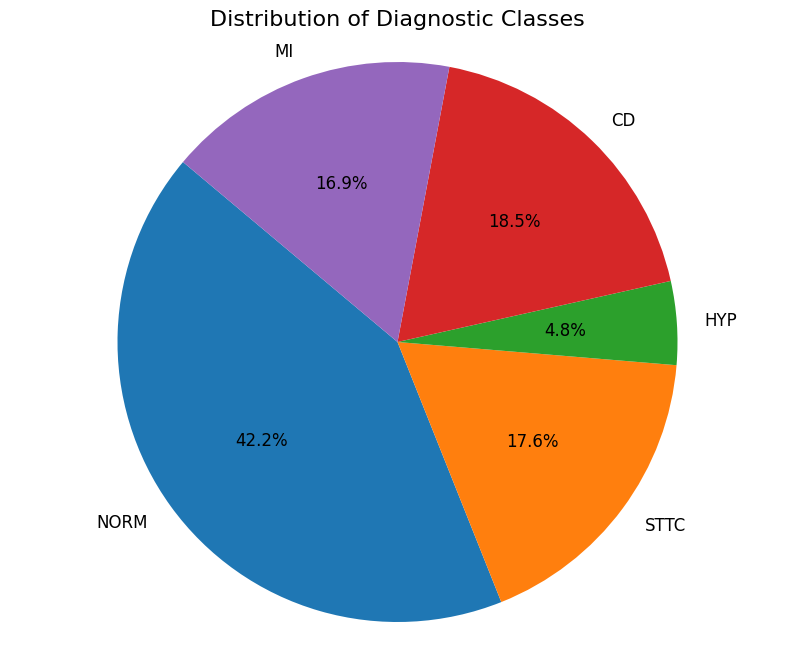

In [10]:
plt.figure(figsize=(10, 8))
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=140,
    textprops={'fontsize': 12}
)
plt.title('Distribution of Diagnostic Classes', fontsize=16)
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
plt.show()

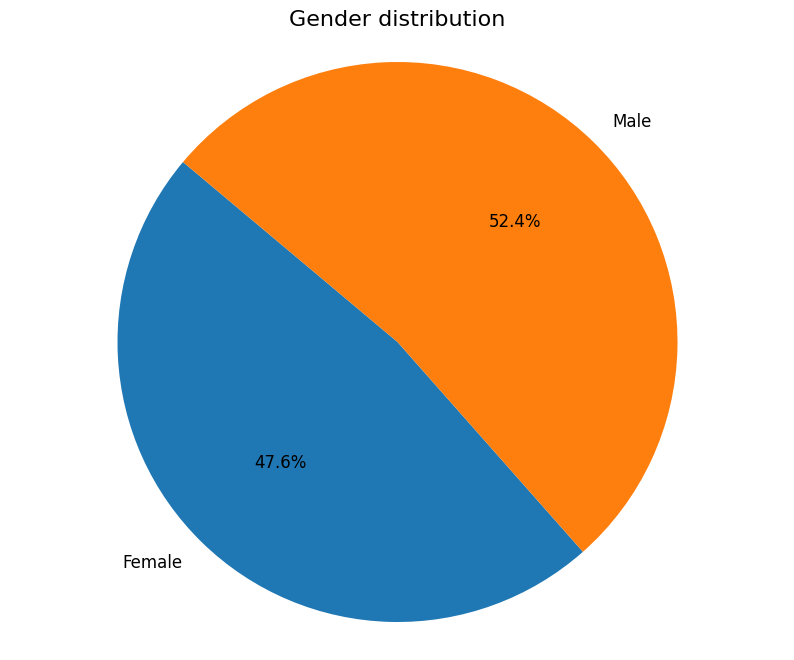

In [11]:
genders = {1: 0,
           0: 0}

for sex in filtered_metadata['sex']:
    genders[sex] += 1

sizes = list(genders.values())

plt.figure(figsize=(10, 8))
plt.pie(
    sizes,
    labels=['Female', 'Male'],
    autopct='%1.1f%%',
    startangle=140,
    textprops={'fontsize': 12}
)
plt.title('Gender distribution', fontsize=16)
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
plt.show()

In [42]:
filtered_metadata.shape

(16966, 30)

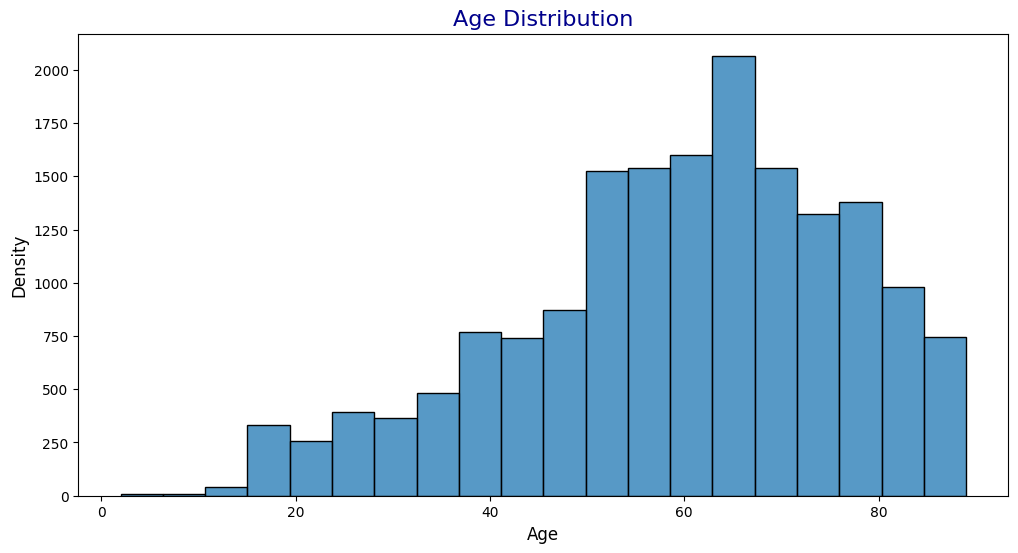

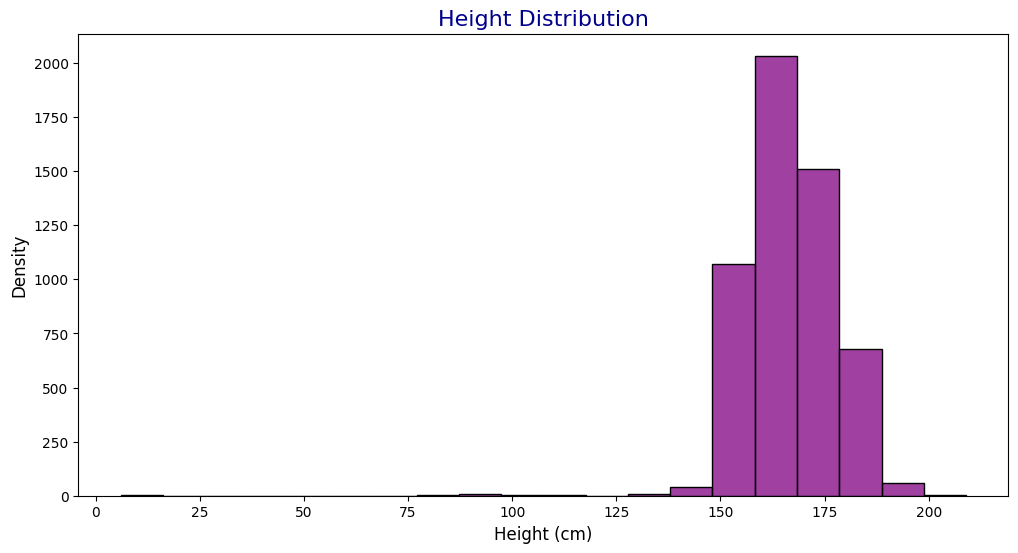

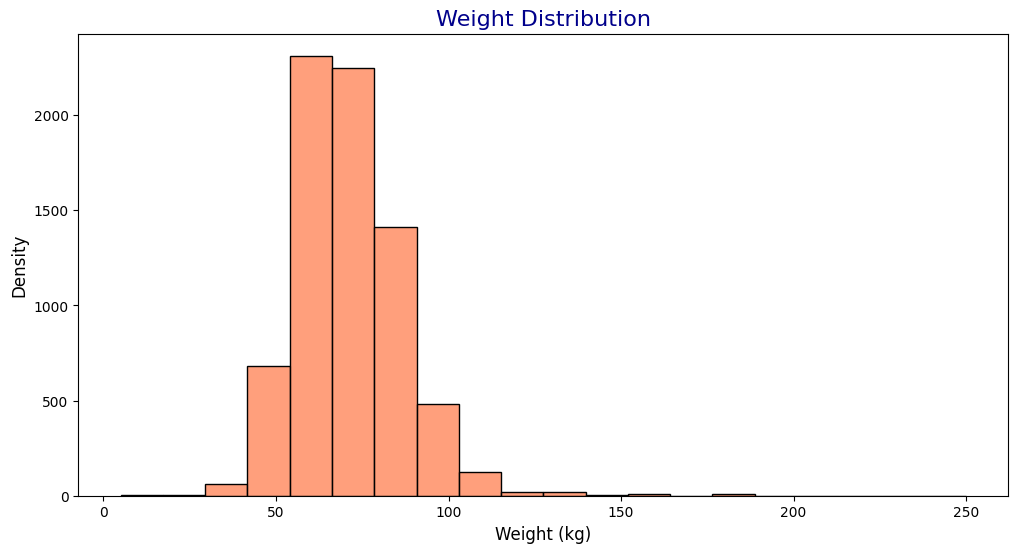

In [12]:
# 1. Univariate analysis - Histogram with KDE overlay for age
plt.figure(figsize=(12, 6))
sns.histplot(filtered_metadata['age'], bins=20)
plt.title('Age Distribution', fontsize=16, color='darkblue')
plt.xlabel('Age', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.show()

# 2. Univariate analysis - Histogram with KDE overlay for height
plt.figure(figsize=(12, 6))
sns.histplot(filtered_metadata['height'], bins=20, color="purple")
plt.title('Height Distribution', fontsize=16, color='darkblue')
plt.xlabel('Height (cm)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.show()

# 3. Univariate analysis - Histogram with KDE overlay for weight
plt.figure(figsize=(12, 6))
sns.histplot(filtered_metadata['weight'], bins=20, color="coral")
plt.title('Weight Distribution', fontsize=16, color='darkblue')
plt.xlabel('Weight (kg)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.show()

In [10]:
sttc_data = filtered_metadata[filtered_metadata['diagnostic_class'] == 'STTC']
norm_data = filtered_metadata[filtered_metadata['diagnostic_class'] == 'NORM']
mi_data = filtered_metadata[filtered_metadata['diagnostic_class'] == 'MI']
cd_data = filtered_metadata[filtered_metadata['diagnostic_class'] == 'CD']
hyp_data = filtered_metadata[filtered_metadata['diagnostic_class'] == 'HYP'] 
print(len(sttc_data), len(norm_data), len(mi_data), len(cd_data), len(hyp_data))

2992 7152 2860 3144 818


In [11]:
norm_data.head()

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,diagnostic_class
0,1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,...,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr,NORM
2,3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,...,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr,NORM
3,4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,...,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr,NORM
4,5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,...,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr,NORM
5,6,19005.0,18.0,1,NaN,58.0,2.0,0.0,CS-12 E,1984-11-28 13:32:13,...,", V1",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00006_lr,records500/00000/00006_hr,NORM


In [12]:
def get_signal_data(path):
    record = wfdb.rdrecord(path)
    signals = record.p_signal
    signal_names = record.sig_name
    return signals, signal_names


def get_time_axis(signal, fs):
    return np.arange(len(signal)) / fs

In [13]:
def plot_all_12_leads(signals, signal_names, diagnos_name, color=None):
    num_leads = len(signal_names)  # Number of ECG leads
    fig, axes = plt.subplots(nrows=num_leads, ncols=1, figsize=(12, 3 * num_leads), constrained_layout=True)

    for i, lead_name in enumerate(signal_names):
        axes[i].plot(signals[:, i])
        axes[i].set_title(f"ECG Lead: {lead_name}")
        axes[i].set_xlabel("Time (samples)")
        axes[i].set_ylabel("Amplitude (mV)")
    plt.suptitle(f"{diagnos_name} ECG signal", fontsize=16, y=1.02)
    plt.show()


In [14]:
pth_norm = 'records500/00000/00001_hr'
pth_sttc = 'records500/00000/00028_hr'
pth_mi = 'records500/00000/00181_hr'
pth_cd = 'records500/00000/00049_hr'
pth_hyp = 'records500/00000/00191_hr'

norm_sigs, norm_sigs_names = get_signal_data(pth_norm)
sttc_sigs, sttc_sigs_names = get_signal_data(pth_sttc)
mi_sigs, mi_sigs_names = get_signal_data(pth_mi)
cd_sigs, cd_sigs_names = get_signal_data(pth_cd)
hyp_sigs, hyp_sigs_names = get_signal_data(pth_hyp)

In [ ]:
plot_all_12_leads(norm_sigs, norm_sigs_names, 'Normal')
plot_all_12_leads(sttc_sigs, sttc_sigs_names, 'ST/T Change')
plot_all_12_leads(mi_sigs, mi_sigs_names, 'Myocardial Infarction')
plot_all_12_leads(cd_sigs, cd_sigs_names, 'Conduction Disturbance')
plot_all_12_leads(hyp_sigs, hyp_sigs_names, 'Hypertrophy')

In [22]:
def get_signal_by_lead(signals, signal_names, lead_name):
    lead_index = signal_names.index(lead_name)  # Find index of Lead
    return signals[:, lead_index]

def plot_ecg_signal(signal, diagnosis_name, color=None):
    plt.figure(figsize=(8, 2))
    plt.plot(signal)
    plt.title(f"ECG {diagnosis_name} Lead: II")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude (mV)")
    plt.show()

In [23]:
norm_signal = get_signal_by_lead(norm_sigs, norm_sigs_names, 'II')
sttc_signal = get_signal_by_lead(sttc_sigs, sttc_sigs_names, 'II')
mi_signal = get_signal_by_lead(mi_sigs, mi_sigs_names, 'II')
cd_signal = get_signal_by_lead(cd_sigs, cd_sigs_names, 'II')
hyp_signal = get_signal_by_lead(hyp_sigs, hyp_sigs_names, 'II')

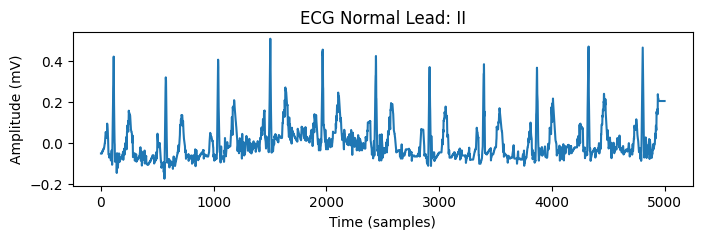

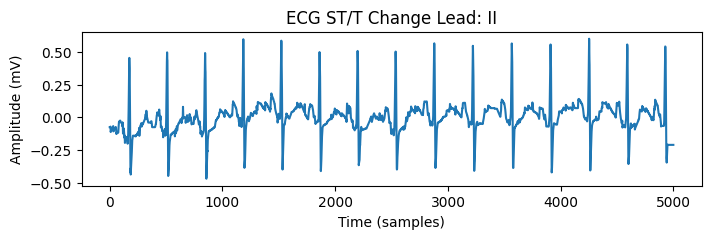

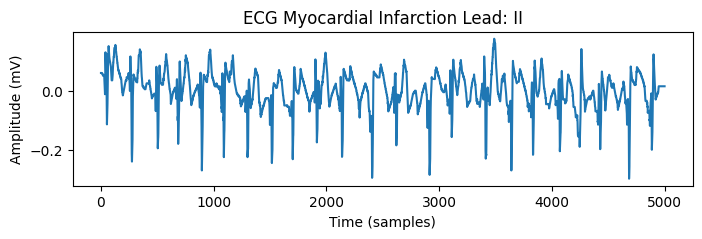

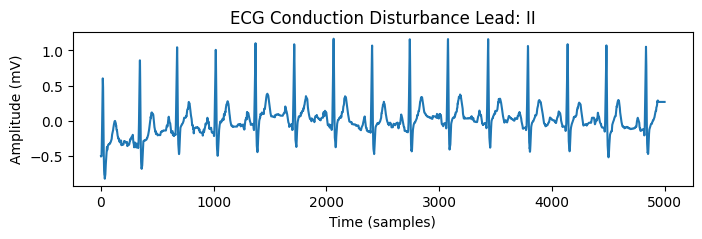

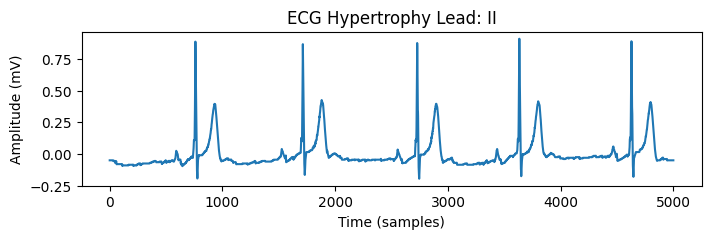

In [24]:
plot_ecg_signal(norm_signal, 'Normal')
plot_ecg_signal(sttc_signal, 'ST/T Change')
plot_ecg_signal(mi_signal, 'Myocardial Infarction')
plot_ecg_signal(cd_signal, 'Conduction Disturbance')
plot_ecg_signal(hyp_signal, 'Hypertrophy')

In [25]:
def plot_original_filtered(original, filtered):
    plt.figure(figsize=(12, 6))
    time = get_time_axis(original, fs=500)
    # Subplot 1: Original signal
    plt.subplot(2, 1, 1)
    plt.plot(time, original, color='blue')
    plt.title('Original ECG Signal')
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude (mV)')
    plt.grid(True)

    # Subplot 2: Filtered signal
    plt.subplot(2, 1, 2)
    plt.plot(time, filtered, color='green')
    plt.title('Filtered ECG Signal (Bandpass filter)')
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude (mV)')
    plt.grid(True)
    
    plt.tight_layout()

    plt.show()

def butter_bandpass_filter(signal, sample_rate, order=2):
    """
    Apply a Butterworth bandpass filter to a signal.
    
    Parameters:
        signal (numpy.ndarray): The input ECG signal.
        sample_rate (int): The sample rate of the signal in Hz.
        lowcut (float): The low cutoff frequency in Hz.
        highcut (float): The high cutoff frequency in Hz.
        order (int): The order of the Butterworth filter.
    
    Returns:
        numpy.ndarray: The filtered signal.
    """
    nyquist = 0.5 * sample_rate  # Nyquist frequency
    norm_cuts_offs = [5 / nyquist, 20 / nyquist]

    
    # Design the Butterworth bandpass filter
    b, a = butter(order, norm_cuts_offs, btype='bandpass')
    
    # Apply the filter to the signal using filtfilt for zero-phase filtering
    filtered_signal = filtfilt(b, a, signal, padlen=150)
    return filtered_signal


lowcut = 0.5  # Avoid breathing noise
highcut = 45  # Avoid power-line noise
sample_rate = 500  # Example sample rate
filt_norm = butter_bandpass_filter(signal=norm_signal, 
                                   sample_rate=sample_rate)

filt_sttc = butter_bandpass_filter(signal=sttc_signal, 
                                   sample_rate=sample_rate)

filt_mi = butter_bandpass_filter(signal=mi_signal, 
                                   sample_rate=sample_rate)

filt_cd = butter_bandpass_filter(signal=cd_signal, 
                                   sample_rate=sample_rate)

filt_hyp = butter_bandpass_filter(signal=hyp_signal, 
                                   sample_rate=sample_rate)

def pan_tompkins(signal, fs):
    # Bandpass filter the signal (0.5-50 Hz) to focus on QRS complex
    lowcut = 5
    highcut = 20
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(3, [low, high], btype=('bandpass'))
    filtered_signal = filtfilt(b, a, signal)
    
    # Differentiate the signal to highlight the QRS complex
    diff_signal = np.diff(filtered_signal)
    
    # Square the signal to emphasize the QRS complex
    squared_signal = diff_signal ** 2
    
    # Integrate the signal (moving window integration)
    integration_window = int(0.08 * fs)  # 80 ms window
    integrated_signal = np.convolve(squared_signal, np.ones(integration_window) / integration_window, mode='same')
    
    # Find peaks in the integrated signal (R-peaks)
    threshold = 0.4 * max(integrated_signal)
    peaks, _ = find_peaks(integrated_signal, height=threshold, distance=round(0.2 * fs))
    
    return peaks

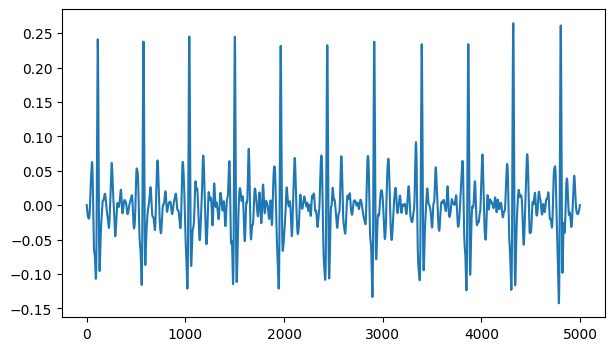

In [31]:
plt.figure(figsize=(7, 4))
plt.plot(filt_norm)
plt.show()

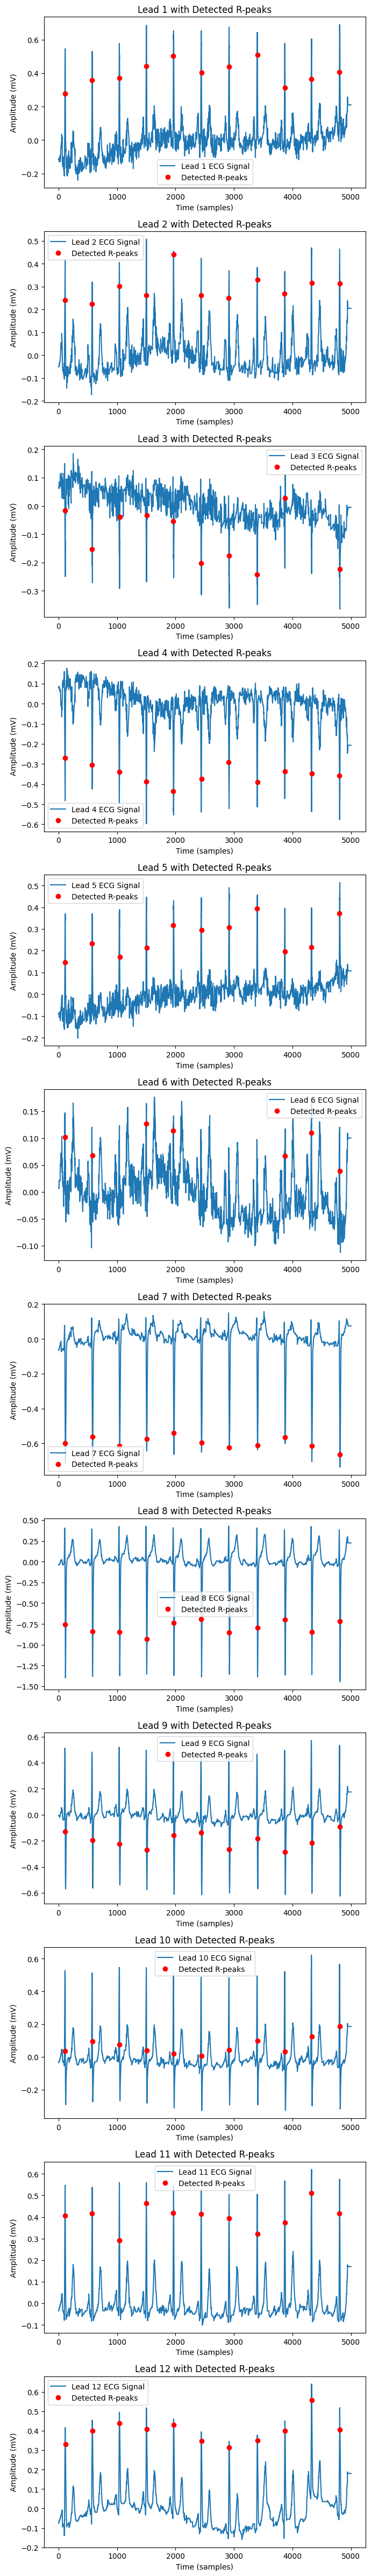

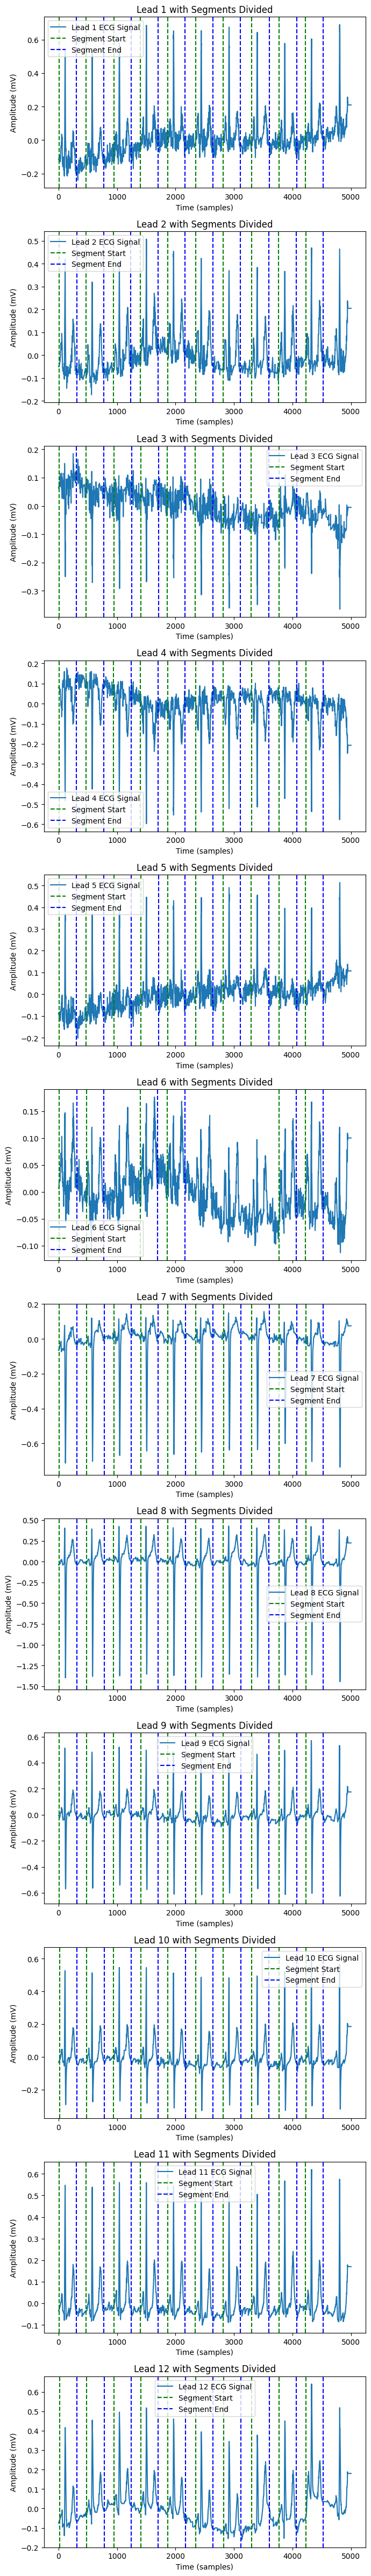

In [29]:
def plot_detected_peaks(signal, fs=500):
    num_leads = signal.shape[1]  # Number of leads in the signal
    
    plt.figure(figsize=(7, 4 * num_leads))
    
    for lead_idx in range(num_leads):
        lead_signal = signal[:, lead_idx]
        
        peaks = pan_tompkins(lead_signal, fs)
        
        # Create the subplot for the current lead
        plt.subplot(num_leads, 1, lead_idx + 1)
        plt.plot(lead_signal, label=f"Lead {lead_idx + 1} ECG Signal")
        plt.plot(peaks, lead_signal[peaks], "ro", label="Detected R-peaks")
        
        plt.title(f"Lead {lead_idx + 1} with Detected R-peaks")
        plt.xlabel("Time (samples)")
        plt.ylabel("Amplitude (mV)")
        plt.legend()
    
    plt.tight_layout()
    plt.show()

def plot_segments_with_dotted_lines(signal, fs=500, window_before=0.2, window_after=0.4):
    num_leads = signal.shape[1]  # Number of leads in the signal
    
    plt.figure(figsize=(7, 4 * num_leads))
    
    samples_before = int(window_before * fs)
    samples_after = int(window_after * fs)
    
    for lead_idx in range(num_leads):
        lead_signal = signal[:, lead_idx]
        
        peaks = pan_tompkins(lead_signal, fs)
        
        # Create the subplot for the current lead
        # Create the subplot for the current lead
        plt.subplot(num_leads, 1, lead_idx + 1)
        plt.plot(lead_signal, label=f"Lead {lead_idx + 1} ECG Signal")
        
        # Mark the segments (dotted lines) with different colors for start and end
        for peak in peaks:
            start = peak - samples_before
            end = peak + samples_after
            if start >= 0 and end < len(lead_signal):
                # Dotted line for start (green)
                plt.axvline(x=start, color='g', linestyle='--', label="Segment Start" if peak == peaks[0] else "")
                # Dotted line for end (blue)
                plt.axvline(x=end, color='b', linestyle='--', label="Segment End" if peak == peaks[0] else "")
        
        plt.title(f"Lead {lead_idx + 1} with Segments Divided")
        plt.xlabel("Time (samples)")
        plt.ylabel("Amplitude (mV)")
        
        # Remove duplicate labels in the legend
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))  # Remove duplicates by label
        plt.legend(by_label.values(), by_label.keys())
    
    plt.tight_layout()
    plt.show()


plot_detected_peaks(norm_sigs)

# Plot the segments with dotted lines for each lead
plot_segments_with_dotted_lines(norm_sigs)

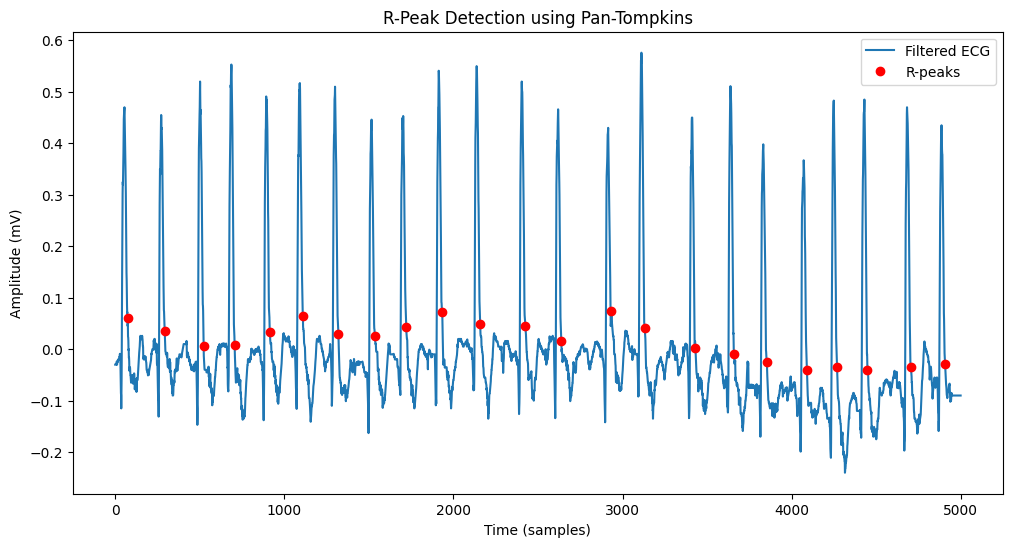

In [49]:
def pan_tompkins(filtered_signal, fs):
    derivative_signal = np.diff(filtered_signal)
    squared_signal = derivative_signal ** 2
    window_size = int(0.08 * fs)
    integrated_signal = np.zeros_like(squared_signal)
    cumulative_sum = squared_signal.cumsum()
    integrated_signal[window_size:] = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size
    integrated_signal[:window_size] = cumulative_sum[:window_size] / np.arange(1, window_size + 1)
    return integrated_signal


signal, _ = get_signal_data('records500/00000/00181_hr')
lead = signal[:, 0]
filt = butter_bandpass_filter(lead, 500)
integrated_sig_norm = pan_tompkins(filt, 500)
threshold = 0.4 * max(integrated_sig_norm)
peaks, _ = find_peaks(integrated_sig_norm, height=threshold, distance=round(500 * 0.2))


plt.figure(figsize=(12, 6))
plt.plot(lead, label="Filtered ECG")
plt.plot(peaks, lead[peaks], "ro", label="R-peaks")
plt.title("R-Peak Detection using Pan-Tompkins")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude (mV)")
plt.legend()
plt.show()


In [ ]:
plot_original_filtered(norm_signal, filt_norm)
plot_original_filtered(sttc_signal, filt_sttc)
plot_original_filtered(mi_signal, filt_mi)
plot_original_filtered(cd_signal, filt_cd)
plot_original_filtered(hyp_signal, filt_hyp)

In [ ]:
plot_original_filtered(norm_signal, filt_norm)
plot_original_filtered(sttc_signal, filt_sttc)
plot_original_filtered(mi_signal, filt_mi)
plot_original_filtered(cd_signal, filt_cd)
plot_original_filtered(hyp_signal, filt_hyp)

Реалізація (спроба)

In [12]:
label_mapping = {'NORM': 0, 'HYP': 1, 'CD': 1, 'MI': 1, 'STTC': 1}
filtered_metadata['binary_class'] = filtered_metadata['diagnostic_class'].map(label_mapping)

filtered_metadata['filename_hr'].values
filtered_metadata['binary_class'].values


C:\Users\Admin\AppData\Local\Temp\ipykernel_18084\3967990187.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_metadata['binary_class'] = filtered_metadata['diagnostic_class'].map(label_mapping)


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

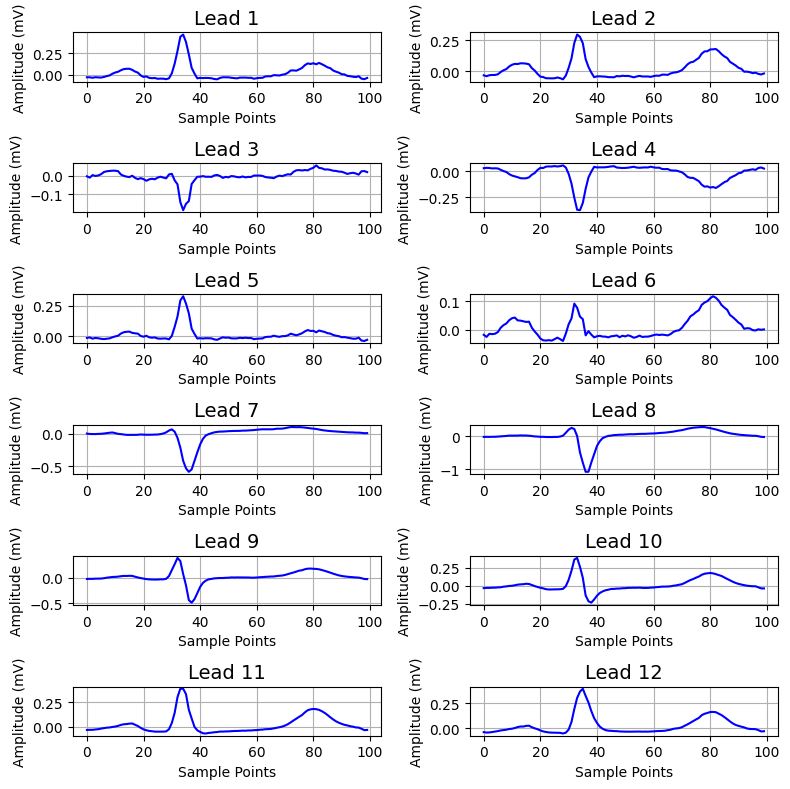

In [ ]:
def segment_ecg_aaa(signals, fs, window_before=0.2, window_after=0.4):
    """
    Segment 12-lead ECG signals around R-peaks and return the average QRS complex.
    
    Parameters:
    - signals: np.ndarray, shape (samples, leads)
    - fs: int, sampling frequency
    
    Returns:
    - average_segment: np.ndarray, shape (100, 12)
    """
    num_leads = signals.shape[1]
    lead_r_peaks = []
    
    # Detect R-peaks on all leads
    for lead_idx in range(num_leads):
        lead_signal = signals[:, lead_idx]
        r_peaks = pan_tompkins(lead_signal, fs)
        lead_r_peaks.append(r_peaks)
    
    # Use R-peaks from Lead II (commonly the reference lead)
    r_peaks = lead_r_peaks[1]  # Assuming Lead II is the second lead
    
    # Convert time windows to samples
    samples_before = int(window_before * fs)
    samples_after = int(window_after * fs)
    segment_length = samples_before + samples_after

    # Create segments and resample
    segments = []
    for r_peak in r_peaks:
        start = r_peak - samples_before
        end = r_peak + samples_after
        
        # Extract segments from all leads
        segment = signals[max(0, start):min(signals.shape[0], end), :]
        
        # Pad if the segment is incomplete
        if segment.shape[0] < segment_length:
            segment = np.pad(segment, 
                             ((0, segment_length - segment.shape[0]), (0, 0)), 
                             mode='constant', constant_values=0)
        
        # Resample to 100 samples per segment for each lead
        resampled_segment = np.array([resample(segment[:, lead], 100) for lead in range(num_leads)]).T
        segments.append(resampled_segment)
    
    # Calculate the mean of all segments
    average_segment = np.mean(segments, axis=0)

    return average_segment

segs = segment_ecg_aaa(norm_sigs, 500)

num_leads = segs.shape[1]
time_points = np.arange(segs.shape[0])

plt.figure(figsize=(8, 8))

for lead in range(num_leads):
    plt.subplot((num_leads + 1) // 2, 2, lead + 1)  # Arrange in a grid (2 columns)
    plt.plot(time_points, segs[:, lead], label=f'Lead {lead + 1}', color='blue')
    plt.title(f'Lead {lead + 1}', fontsize=14)
    plt.xlabel('Sample Points', fontsize=10)
    plt.ylabel('Amplitude (mV)', fontsize=10)
    plt.grid()
    plt.tight_layout()

plt.show()





In [41]:
label_mapping = {'NORM': 0, 'HYP': 1, 'CD': 1, 'MI': 1, 'STTC': 1}
filtered_metadata['binary_class'] = filtered_metadata['diagnostic_class'].map(label_mapping)

filtered_metadata['filename_hr'].values
filtered_metadata['binary_class'].values
filtered_metadata = filtered_metadata.reset_index(drop=True)


Training binary

In [43]:
def pan_tompkins(signal, fs):
    # Bandpass filter the signal (0.5-50 Hz) to focus on QRS complex
    lowcut = 5
    highcut = 20
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(1, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)
    
    # Differentiate the signal to highlight the QRS complex
    diff_signal = np.diff(filtered_signal)
    
    # Square the signal to emphasize the QRS complex
    squared_signal = diff_signal ** 2
    
    # Integrate the signal (moving window integration)
    integration_window = int(0.08 * fs)  # 80 ms window
    integrated_signal = np.convolve(squared_signal, np.ones(integration_window) / integration_window, mode='same')
    
    # Find peaks in the integrated signal (R-peaks)
    threshold = 0.5 * max(integrated_signal)
    peaks, _ = find_peaks(integrated_signal, height=threshold, distance=round(0.2 * fs))
    
    return peaks


# Segmenting function
def segment_ecg(signals, fs, window_before=0.2, window_after=0.4):
    """
    Segment 12-lead ECG signals around R-peaks and return the average QRS complex.
    
    Parameters:
    - signals: np.ndarray, shape (samples, leads)
    - fs: int, sampling frequency
    
    Returns:
    - average_segment: np.ndarray, shape (100, 12)
    """
    num_leads = signals.shape[1]
    lead_r_peaks = []
    
    # Detect R-peaks on all leads
    for lead_idx in range(num_leads):
        lead_signal = signals[:, lead_idx]
        r_peaks = pan_tompkins(lead_signal, fs)
        lead_r_peaks.append(r_peaks)
    
    # Use R-peaks from Lead II (commonly the reference lead)
    r_peaks = lead_r_peaks[1]  # Assuming Lead II is the second lead
    
    # Convert time windows to samples
    samples_before = int(window_before * fs)
    samples_after = int(window_after * fs)

    # Create segments and resample
    segments = []
    for r_peak in r_peaks:
        start = r_peak - samples_before
        end = r_peak + samples_after
        segment_length = samples_before + samples_after
        # Extract segments from all leads
        segment = signals[max(0, start):min(signals.shape[0], end), :]
       # Pad if the segment is incomplete
        if segment.shape[0] < segment_length:
            segment = np.pad(segment, 
                             ((0, segment_length - segment.shape[0]), (0, 0)), 
                             mode='constant', constant_values=0)
        
        # Resample to 100 samples per segment for each lead
        resampled_segment = np.array([resample(segment[:, lead], 100) for lead in range(num_leads)]).T
        segments.append(resampled_segment)
    
    # Calculate the mean of all segments
    average_segment = np.mean(segments, axis=0)

    return average_segment


class ECGDataset(Dataset):
    def __init__(self, metadata, fs=500):
        self.metadata = metadata
        self.fs = fs

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        record_name = self.metadata.iloc[idx]['filename_hr']
        label = self.metadata.iloc[idx]['binary_class']

        # Load the signal (adjust file loading logic based on your setup)
        record = wfdb.rdrecord(record_name)
        signals = record.p_signal

        # Segment the ECG
        segments = segment_ecg(signals, self.fs)
        
        return torch.tensor(segments, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


# Assuming filtered_metadata is your initial metadata

# Split dataset
train_metadata, test_metadata = train_test_split(filtered_metadata, test_size=0.2, stratify=filtered_metadata['binary_class'])

train_dataset = ECGDataset(train_metadata)
test_dataset = ECGDataset(test_metadata)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [34]:


# Model definition
class ECGSegmentClassifier(nn.Module):
    def __init__(self, num_classes=2):
        super(ECGSegmentClassifier, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Flatten()
        )
        self.fc = nn.Sequential(
            nn.Linear(64 * 25 * 3, 128),  # Adjust based on input size
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = self.cnn(x)
        x = self.fc(x)
        return x


def train_model(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct_preds = 0
    total_preds = 0
    for batch in tqdm(dataloader):
        segments, labels = batch
        segments, labels = segments.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(segments)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_preds += (predicted == labels).sum().item()
        total_preds += labels.size(0)
    
    avg_loss = total_loss / len(dataloader)
    accuracy = correct_preds / total_preds
    return avg_loss, accuracy

def evaluate_model_with_metrics(model, val_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    class_correct = [0] * 2  # Assuming binary classification (adjust for more classes)
    class_total = [0] * 2  # Adjust for more classes
    
    with torch.no_grad():  # No need to calculate gradients during evaluation
        for inputs, labels in tqdm(val_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass through the model
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Get predictions
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            
            # Collect predictions and labels for F1 score and other metrics
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            # Class-wise accuracy tracking
            for i in range(len(labels)):
                label = labels[i].item()
                class_total[label] += 1
                if predicted[i].item() == label:
                    class_correct[label] += 1
    
    # Calculate average validation loss
    avg_val_loss = val_loss / len(val_loader)
    
    # Calculate accuracy and F1 score
    val_accuracy = correct / total
    val_f1 = f1_score(all_labels, all_preds, average='weighted')  # You can change this for other averaging methods
    val_report = classification_report(all_labels, all_preds)
    val_cm = confusion_matrix(all_labels, all_preds)

    # Class-wise accuracy
    class_accuracies = [class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(len(class_correct))]

    return avg_val_loss, val_accuracy, val_f1, val_report, val_cm, class_accuracies



# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ECGSegmentClassifier().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
train_f1s, val_f1s = [], []

for epoch in range(10):
    print(f'Epoch: {epoch + 1}')

    # Training
    train_loss, train_accuracy = train_model(model, train_loader, optimizer, criterion, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    val_loss, val_accuracy, val_f1, val_report, val_cm, class_accuracies = evaluate_model_with_metrics(model, test_loader, criterion, device)
    val_losses.append(val_loss)  # Track validation loss here too
    val_accuracies.append(val_accuracy)
    val_f1s.append(val_f1)

    print(f"Epoch {epoch+1}, Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}, F1 Score: {val_f1:.4f}")
    print(f"Classification Report:\n{val_report}")
    print(f"Confusion Matrix:\n{val_cm}")

    
print("\nAfter all epochs:")
average_general_accuracy = sum(val_accuracies) / len(val_accuracies)
print(f"Average General Accuracy: {average_general_accuracy:.4f}")


Epoch: 1


100%|██████████| 54/54 [01:03<00:00,  1.18s/it]


Epoch 1, Loss: 0.3787, Accuracy: 0.8377
Validation Accuracy: 0.8739, F1 Score: 0.8747
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.94      0.86      1431
           1       0.95      0.83      0.88      1963

    accuracy                           0.87      3394
   macro avg       0.87      0.88      0.87      3394
weighted avg       0.89      0.87      0.87      3394

Confusion Matrix:
[[1345   86]
 [ 342 1621]]
Epoch: 2


100%|██████████| 54/54 [01:03<00:00,  1.17s/it]


Epoch 2, Loss: 0.2975, Accuracy: 0.8767
Validation Accuracy: 0.8913, F1 Score: 0.8913
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      1431
           1       0.91      0.90      0.91      1963

    accuracy                           0.89      3394
   macro avg       0.89      0.89      0.89      3394
weighted avg       0.89      0.89      0.89      3394

Confusion Matrix:
[[1251  180]
 [ 189 1774]]
Epoch: 3


100%|██████████| 54/54 [01:02<00:00,  1.16s/it]


Epoch 3, Loss: 0.2747, Accuracy: 0.8840
Validation Accuracy: 0.8913, F1 Score: 0.8918
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.92      0.88      1431
           1       0.94      0.87      0.90      1963

    accuracy                           0.89      3394
   macro avg       0.89      0.90      0.89      3394
weighted avg       0.90      0.89      0.89      3394

Confusion Matrix:
[[1316  115]
 [ 254 1709]]
Epoch: 4


100%|██████████| 54/54 [01:03<00:00,  1.17s/it]


Epoch 4, Loss: 0.2613, Accuracy: 0.8896
Validation Accuracy: 0.8721, F1 Score: 0.8696
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.75      0.83      1431
           1       0.84      0.96      0.90      1963

    accuracy                           0.87      3394
   macro avg       0.89      0.86      0.86      3394
weighted avg       0.88      0.87      0.87      3394

Confusion Matrix:
[[1078  353]
 [  81 1882]]
Epoch: 5


100%|██████████| 54/54 [01:02<00:00,  1.16s/it]


Epoch 5, Loss: 0.2520, Accuracy: 0.8951
Validation Accuracy: 0.8683, F1 Score: 0.8691
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.96      0.86      1431
           1       0.97      0.80      0.88      1963

    accuracy                           0.87      3394
   macro avg       0.87      0.88      0.87      3394
weighted avg       0.89      0.87      0.87      3394

Confusion Matrix:
[[1375   56]
 [ 391 1572]]
Epoch: 6


100%|██████████| 54/54 [01:07<00:00,  1.25s/it]


Epoch 6, Loss: 0.2502, Accuracy: 0.8950
Validation Accuracy: 0.8942, F1 Score: 0.8941
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.87      0.87      1431
           1       0.90      0.91      0.91      1963

    accuracy                           0.89      3394
   macro avg       0.89      0.89      0.89      3394
weighted avg       0.89      0.89      0.89      3394

Confusion Matrix:
[[1242  189]
 [ 170 1793]]
Epoch: 7


100%|██████████| 54/54 [01:04<00:00,  1.19s/it]


Epoch 7, Loss: 0.2317, Accuracy: 0.9022
Validation Accuracy: 0.8901, F1 Score: 0.8907
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.94      0.88      1431
           1       0.95      0.85      0.90      1963

    accuracy                           0.89      3394
   macro avg       0.89      0.90      0.89      3394
weighted avg       0.90      0.89      0.89      3394

Confusion Matrix:
[[1346   85]
 [ 288 1675]]
Epoch: 8


100%|██████████| 54/54 [01:04<00:00,  1.19s/it]


Epoch 8, Loss: 0.2299, Accuracy: 0.9041
Validation Accuracy: 0.8922, F1 Score: 0.8912
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.82      0.87      1431
           1       0.88      0.94      0.91      1963

    accuracy                           0.89      3394
   macro avg       0.90      0.88      0.89      3394
weighted avg       0.89      0.89      0.89      3394

Confusion Matrix:
[[1177  254]
 [ 112 1851]]
Epoch: 9


100%|██████████| 54/54 [01:09<00:00,  1.29s/it]


Epoch 9, Loss: 0.2277, Accuracy: 0.9038
Validation Accuracy: 0.8963, F1 Score: 0.8965
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      1431
           1       0.92      0.90      0.91      1963

    accuracy                           0.90      3394
   macro avg       0.89      0.90      0.89      3394
weighted avg       0.90      0.90      0.90      3394

Confusion Matrix:
[[1283  148]
 [ 204 1759]]
Epoch: 10


100%|██████████| 54/54 [01:06<00:00,  1.23s/it]

Epoch 10, Loss: 0.2178, Accuracy: 0.9100
Validation Accuracy: 0.8975, F1 Score: 0.8977
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      1431
           1       0.93      0.89      0.91      1963

    accuracy                           0.90      3394
   macro avg       0.89      0.90      0.90      3394
weighted avg       0.90      0.90      0.90      3394

Confusion Matrix:
[[1290  141]
 [ 207 1756]]

After all epochs:
Average General Accuracy: 0.8867


In [ ]:
# Assuming the lists `train_losses`, `train_accuracies`, `val_losses`, `val_accuracies`, and `val_f1s` have been collected
epochs = list(range(1, 11))  # for 10 epochs

# Plotting the loss curves (Training vs Validation)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss', color='b', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', color='r', marker='x')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting the accuracy curves (Training vs Validation)
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy', color='b', marker='o')
plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='r', marker='x')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Plotting the F1 score (Validation)
plt.figure(figsize=(6, 6))
plt.plot(epochs, val_f1s, label='Validation F1 Score', color='g', marker='x')
plt.title('F1 Score per Epoch')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

Evaluating binary

C:\Users\Admin\AppData\Local\Temp\ipykernel_4372\3758356495.py:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('model_binary_cnn.pth')
100%|███████

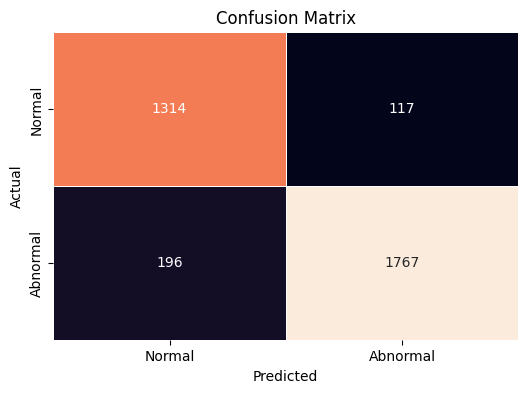


Class-wise Accuracies:
   Class  Accuracy
  Normal  0.918239
Abnormal  0.900153
Validation Accuracy: 0.9078
F1 Score: 0.9081
Classification Report:
              precision    recall  f1-score   support

      Normal       0.87      0.92      0.89      1431
    Abnormal       0.94      0.90      0.92      1963

    accuracy                           0.91      3394
   macro avg       0.90      0.91      0.91      3394
weighted avg       0.91      0.91      0.91      3394

Confusion Matrix:
          Normal  Abnormal
Normal      1314       117
Abnormal     196      1767


In [48]:
class_names = ['Normal', 'Abnormal']
DEVICE = torch.device('cuda')

def evaluate_model_with_metrics(model, val_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    class_correct = [0] * len(class_names)
    class_total = [0] * len(class_names)
    
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            for i in range(len(labels)):
                label = labels[i].item()
                class_total[label] += 1
                if predicted[i].item() == label:
                    class_correct[label] += 1
    
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct / total
    val_f1 = f1_score(all_labels, all_preds, average='weighted')
    val_report = classification_report(all_labels, all_preds, target_names=class_names)
    val_cm = confusion_matrix(all_labels, all_preds)

    # Class-wise accuracy
    class_accuracies = {
        class_names[i]: (class_correct[i] / class_total[i] if class_total[i] > 0 else 0)
        for i in range(len(class_correct))
    }

    # Create confusion matrix DataFrame
    cm_df = pd.DataFrame(val_cm, index=class_names, columns=class_names)

    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_df, annot=True, fmt='d', cbar=False, linewidths=0.5)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    # Class-wise accuracy DataFrame
    class_accuracy_df = pd.DataFrame(
        {"Class": list(class_accuracies.keys()), "Accuracy": list(class_accuracies.values())}
    )

    # Print the class-wise accuracy table
    print("\nClass-wise Accuracies:")
    print(class_accuracy_df.to_string(index=False))

    return avg_val_loss, val_accuracy, val_f1, val_report, cm_df, class_accuracies

# Define your model and criterion
criterion = nn.CrossEntropyLoss()
checkpoint = torch.load('model_binary_cnn.pth')
model = ECGSegmentClassifier().to(DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])

# Evaluate the model
val_loss, val_accuracy, val_f1, val_report, cm_df, class_accuracies = evaluate_model_with_metrics(
    model, test_loader, criterion, DEVICE
)

# Print the results
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"F1 Score: {val_f1:.4f}")
print(f"Classification Report:\n{val_report}")
print(f"Confusion Matrix:\n{cm_df}")


In [61]:
label_mapping = {'NORM': 0, 'HYP': 1, 'CD': 2, 'MI': 3, 'STTC': 4}
filtered_metadata['five_classes'] = filtered_metadata['diagnostic_class'].map(label_mapping)

filtered_metadata['filename_hr'].values
filtered_metadata['five_classes'].values
filtered_metadata = filtered_metadata.reset_index(drop=True)


In [62]:
def pan_tompkins(signal, fs):
    # Bandpass filter the signal (0.5-50 Hz) to focus on QRS complex
    lowcut = 5
    highcut = 20
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(1, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)
    
    # Differentiate the signal to highlight the QRS complex
    diff_signal = np.diff(filtered_signal)
    
    # Square the signal to emphasize the QRS complex
    squared_signal = diff_signal ** 2
    
    # Integrate the signal (moving window integration)
    integration_window = int(0.08 * fs)  # 80 ms window
    integrated_signal = np.convolve(squared_signal, np.ones(integration_window) / integration_window, mode='same')
    
    # Find peaks in the integrated signal (R-peaks)
    threshold = 0.5 * max(integrated_signal)
    peaks, _ = find_peaks(integrated_signal, height=threshold, distance=round(0.2 * fs))
    
    return peaks


# Segmenting function
def segment_ecg(signals, fs, window_before=0.2, window_after=0.4):
    """
    Segment 12-lead ECG signals around R-peaks and return the average QRS complex.
    
    Parameters:
    - signals: np.ndarray, shape (samples, leads)
    - fs: int, sampling frequency
    
    Returns:
    - average_segment: np.ndarray, shape (100, 12)
    """
    num_leads = signals.shape[1]
    lead_r_peaks = []
    
    # Detect R-peaks on all leads
    for lead_idx in range(num_leads):
        lead_signal = signals[:, lead_idx]
        r_peaks = pan_tompkins(lead_signal, fs)
        lead_r_peaks.append(r_peaks)
    
    # Use R-peaks from Lead II (commonly the reference lead)
    r_peaks = lead_r_peaks[1]  # Assuming Lead II is the second lead
    
    # Convert time windows to samples
    samples_before = int(window_before * fs)
    samples_after = int(window_after * fs)

    # Create segments and resample
    segments = []
    for r_peak in r_peaks:
        start = r_peak - samples_before
        end = r_peak + samples_after
        segment_length = samples_before + samples_after
        # Extract segments from all leads
        segment = signals[max(0, start):min(signals.shape[0], end), :]
       # Pad if the segment is incomplete
        if segment.shape[0] < segment_length:
            segment = np.pad(segment, 
                             ((0, segment_length - segment.shape[0]), (0, 0)), 
                             mode='constant', constant_values=0)
        
        # Resample to 100 samples per segment for each lead
        resampled_segment = np.array([resample(segment[:, lead], 100) for lead in range(num_leads)]).T
        segments.append(resampled_segment)
    
    # Calculate the mean of all segments
    average_segment = np.mean(segments, axis=0)

    return average_segment


# Dataset class (unchanged)
class ECGDataset(Dataset):
    def __init__(self, metadata, fs=500):
        self.metadata = metadata
        self.fs = fs

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        record_name = self.metadata.iloc[idx]['filename_hr']
        label = self.metadata.iloc[idx]['five_classes']  # Update column for 5-class labels

        record = wfdb.rdrecord(record_name)
        signals = record.p_signal
        segments = segment_ecg(signals, self.fs)
        
        return torch.tensor(segments, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

# Assuming filtered_metadata is your initial metadata

# Split dataset
train_metadata, test_metadata = train_test_split(
    filtered_metadata,
    test_size=0.2,
    stratify=filtered_metadata['five_classes']  # Update stratify column for 5-class labels
)

train_dataset = ECGDataset(train_metadata)
test_dataset = ECGDataset(test_metadata)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Model definition
class ECGSegmentClassifier(nn.Module):
    def __init__(self, num_classes=5):  # Set num_classes to 5
        super(ECGSegmentClassifier, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Flatten()
        )
        self.fc = nn.Sequential(
            nn.Linear(64 * 25 * 3, 128),  # Adjust based on input size
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = self.cnn(x)
        x = self.fc(x)
        return x

def train_model(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct_preds = 0
    total_preds = 0
    for batch in tqdm(dataloader):
        segments, labels = batch
        segments, labels = segments.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(segments)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_preds += (predicted == labels).sum().item()
        total_preds += labels.size(0)
    
    avg_loss = total_loss / len(dataloader)
    accuracy = correct_preds / total_preds
    return avg_loss, accuracy

def evaluate_model_with_metrics(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    class_correct = [0] * 5  # Adjust for 5 classes
    class_total = [0] * 5
    
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            for i in range(len(labels)):
                label = labels[i].item()
                class_total[label] += 1
                if predicted[i].item() == label:
                    class_correct[label] += 1
    
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct / total
    val_f1 = f1_score(all_labels, all_preds, average='weighted')
    val_report = classification_report(all_labels, all_preds)
    val_cm = confusion_matrix(all_labels, all_preds)
    class_accuracies = [class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(len(class_correct))]

    return avg_val_loss, val_accuracy, val_f1, val_report, val_cm, class_accuracies

# Update model and training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ECGSegmentClassifier(num_classes=5).to(device)  # 5 classes
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
train_f1s, val_f1s = [], []

for epoch in range(10):
    print(f'Epoch: {epoch + 1}')

    # Training
    train_loss, train_accuracy = train_model(model, train_loader, optimizer, criterion, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    val_loss, val_accuracy, val_f1, val_report, val_cm, class_accuracies = evaluate_model_with_metrics(model, test_loader, criterion, device)
    val_losses.append(val_loss)  # Track validation loss here too
    val_accuracies.append(val_accuracy)
    val_f1s.append(val_f1)

    print(f"Epoch {epoch+1}, Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}, F1 Score: {val_f1:.4f}")
    print(f"Classification Report:\n{val_report}")
    print(f"Confusion Matrix:\n{val_cm}")

    
print("\nAfter all epochs:")
average_general_accuracy = sum(val_accuracies) / len(val_accuracies)
print(f"Average General Accuracy: {average_general_accuracy:.4f}")


Epoch: 1


100%|██████████| 54/54 [02:27<00:00,  2.73s/it]


Epoch 1, Loss: 0.9371, Accuracy: 0.6441
Validation Accuracy: 0.7245, F1 Score: 0.7141
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1431
           1       0.70      0.26      0.38       164
           2       0.70      0.49      0.58       629
           3       0.62      0.65      0.63       572
           4       0.59      0.72      0.65       598

    accuracy                           0.72      3394
   macro avg       0.69      0.61      0.62      3394
weighted avg       0.72      0.72      0.71      3394

Confusion Matrix:
[[1306    1   40   11   73]
 [  21   43    7   39   54]
 [ 127    1  310  119   72]
 [  35    4   67  370   96]
 [  79   12   18   59  430]]
Epoch: 2


100%|██████████| 54/54 [01:15<00:00,  1.39s/it]


Epoch 2, Loss: 0.7438, Accuracy: 0.7215
Validation Accuracy: 0.7334, F1 Score: 0.7254
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.92      0.88      1431
           1       0.50      0.49      0.50       164
           2       0.58      0.74      0.65       629
           3       0.81      0.42      0.56       572
           4       0.67      0.64      0.65       598

    accuracy                           0.73      3394
   macro avg       0.68      0.64      0.65      3394
weighted avg       0.74      0.73      0.73      3394

Confusion Matrix:
[[1319    6   72    3   31]
 [  16   81   23    6   38]
 [  87   10  467   28   37]
 [  31   31  183  242   85]
 [  99   35   65   19  380]]
Epoch: 3


100%|██████████| 54/54 [01:17<00:00,  1.43s/it]


Epoch 3, Loss: 0.6963, Accuracy: 0.7392
Validation Accuracy: 0.7584, F1 Score: 0.7520
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.94      0.88      1431
           1       0.55      0.49      0.52       164
           2       0.74      0.60      0.66       629
           3       0.68      0.71      0.70       572
           4       0.70      0.62      0.66       598

    accuracy                           0.76      3394
   macro avg       0.70      0.67      0.68      3394
weighted avg       0.75      0.76      0.75      3394

Confusion Matrix:
[[1338    3   40   18   32]
 [  21   81    9   20   33]
 [ 110    6  377   94   42]
 [  31   22   60  408   51]
 [ 115   36   21   56  370]]
Epoch: 4


100%|██████████| 54/54 [01:16<00:00,  1.42s/it]


Epoch 4, Loss: 0.6520, Accuracy: 0.7546
Validation Accuracy: 0.7504, F1 Score: 0.7355
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.97      0.87      1431
           1       0.71      0.25      0.37       164
           2       0.77      0.54      0.63       629
           3       0.75      0.64      0.69       572
           4       0.63      0.69      0.66       598

    accuracy                           0.75      3394
   macro avg       0.73      0.62      0.65      3394
weighted avg       0.75      0.75      0.74      3394

Confusion Matrix:
[[1388    0   16    6   21]
 [  29   41    7   26   61]
 [ 154    3  339   64   69]
 [  45    4   66  367   90]
 [ 137   10   11   28  412]]
Epoch: 5


100%|██████████| 54/54 [01:04<00:00,  1.20s/it]


Epoch 5, Loss: 0.6330, Accuracy: 0.7634
Validation Accuracy: 0.7711, F1 Score: 0.7628
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.94      0.90      1431
           1       0.68      0.30      0.42       164
           2       0.74      0.65      0.69       629
           3       0.70      0.69      0.69       572
           4       0.67      0.69      0.68       598

    accuracy                           0.77      3394
   macro avg       0.73      0.66      0.68      3394
weighted avg       0.76      0.77      0.76      3394

Confusion Matrix:
[[1349    0   31   20   31]
 [  21   49   11   30   53]
 [  98    3  407   68   53]
 [  27    4   79  397   65]
 [  87   16   24   56  415]]
Epoch: 6


100%|██████████| 54/54 [01:01<00:00,  1.14s/it]


Epoch 6, Loss: 0.6044, Accuracy: 0.7720
Validation Accuracy: 0.7764, F1 Score: 0.7720
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.94      0.90      1431
           1       0.56      0.47      0.51       164
           2       0.73      0.67      0.70       629
           3       0.77      0.66      0.71       572
           4       0.67      0.70      0.68       598

    accuracy                           0.78      3394
   macro avg       0.72      0.69      0.70      3394
weighted avg       0.77      0.78      0.77      3394

Confusion Matrix:
[[1341    2   37    8   43]
 [  21   77    9   16   41]
 [  91    9  423   55   51]
 [  31   14   79  375   73]
 [  79   36   29   35  419]]
Epoch: 7


100%|██████████| 54/54 [01:02<00:00,  1.17s/it]


Epoch 7, Loss: 0.5881, Accuracy: 0.7759
Validation Accuracy: 0.7693, F1 Score: 0.7631
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.94      0.89      1431
           1       0.54      0.50      0.52       164
           2       0.73      0.67      0.70       629
           3       0.68      0.75      0.71       572
           4       0.75      0.56      0.64       598

    accuracy                           0.77      3394
   macro avg       0.71      0.68      0.69      3394
weighted avg       0.77      0.77      0.76      3394

Confusion Matrix:
[[1344    7   47   11   22]
 [  19   82   10   32   21]
 [  88    9  421   84   27]
 [  30   11   61  430   40]
 [ 109   43   35   77  334]]
Epoch: 8


100%|██████████| 54/54 [01:03<00:00,  1.17s/it]


Epoch 8, Loss: 0.5703, Accuracy: 0.7871
Validation Accuracy: 0.7669, F1 Score: 0.7661
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89      1431
           1       0.48      0.63      0.54       164
           2       0.69      0.71      0.70       629
           3       0.69      0.76      0.72       572
           4       0.76      0.56      0.65       598

    accuracy                           0.77      3394
   macro avg       0.70      0.71      0.70      3394
weighted avg       0.77      0.77      0.77      3394

Confusion Matrix:
[[1284   15   72   18   42]
 [  16  104   11   18   15]
 [  70   16  444   74   25]
 [  19   20   74  434   25]
 [  66   63   47   85  337]]
Epoch: 9


100%|██████████| 54/54 [01:02<00:00,  1.16s/it]


Epoch 9, Loss: 0.5509, Accuracy: 0.7925
Validation Accuracy: 0.7793, F1 Score: 0.7731
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.94      0.90      1431
           1       0.64      0.37      0.47       164
           2       0.77      0.63      0.69       629
           3       0.77      0.68      0.72       572
           4       0.64      0.76      0.69       598

    accuracy                           0.78      3394
   macro avg       0.74      0.68      0.69      3394
weighted avg       0.78      0.78      0.77      3394

Confusion Matrix:
[[1348    2   29    8   44]
 [  17   61    8   23   55]
 [ 101    4  396   54   74]
 [  30   10   63  388   81]
 [  76   18   19   33  452]]
Epoch: 10


100%|██████████| 54/54 [01:03<00:00,  1.17s/it]

Epoch 10, Loss: 0.5316, Accuracy: 0.7987
Validation Accuracy: 0.7796, F1 Score: 0.7753
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      1431
           1       0.58      0.45      0.50       164
           2       0.70      0.73      0.71       629
           3       0.71      0.74      0.73       572
           4       0.74      0.61      0.67       598

    accuracy                           0.78      3394
   macro avg       0.72      0.69      0.70      3394
weighted avg       0.77      0.78      0.78      3394

Confusion Matrix:
[[1326    3   64   15   23]
 [  17   73   16   26   32]
 [  70    3  458   72   26]
 [  17    8   73  424   50]
 [  90   39   47   57  365]]

After all epochs:
Average General Accuracy: 0.7609


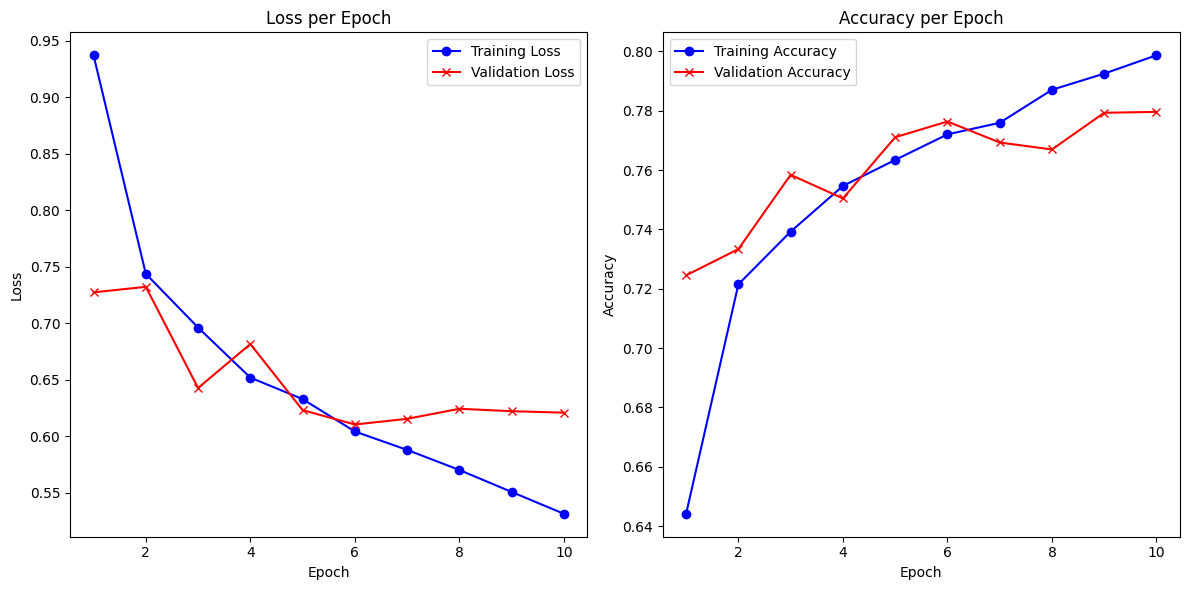

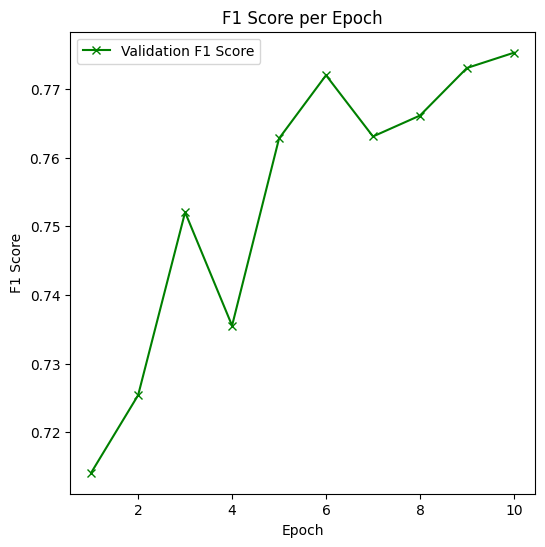

In [63]:
# Assuming the lists `train_losses`, `train_accuracies`, `val_losses`, `val_accuracies`, and `val_f1s` have been collected
epochs = list(range(1, 11))  # for 10 epochs

# Plotting the loss curves (Training vs Validation)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss', color='b', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', color='r', marker='x')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting the accuracy curves (Training vs Validation)
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy', color='b', marker='o')
plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='r', marker='x')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Plotting the F1 score (Validation)
plt.figure(figsize=(6, 6))
plt.plot(epochs, val_f1s, label='Validation F1 Score', color='g', marker='x')
plt.title('F1 Score per Epoch')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

Evaluating multiclass

In [52]:
label_mapping = {'NORM': 0, 'HYP': 1, 'CD': 2, 'MI': 3, 'STTC': 4}
filtered_metadata['five_classes'] = filtered_metadata['diagnostic_class'].map(label_mapping)

filtered_metadata['filename_hr'].values
filtered_metadata['five_classes'].values
filtered_metadata = filtered_metadata.reset_index(drop=True)

def pan_tompkins(signal, fs):
    # Bandpass filter the signal (0.5-50 Hz) to focus on QRS complex
    lowcut = 5
    highcut = 20
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(1, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)
    
    # Differentiate the signal to highlight the QRS complex
    diff_signal = np.diff(filtered_signal)
    
    # Square the signal to emphasize the QRS complex
    squared_signal = diff_signal ** 2
    
    # Integrate the signal (moving window integration)
    integration_window = int(0.08 * fs)  # 80 ms window
    integrated_signal = np.convolve(squared_signal, np.ones(integration_window) / integration_window, mode='same')
    
    # Find peaks in the integrated signal (R-peaks)
    threshold = 0.5 * max(integrated_signal)
    peaks, _ = find_peaks(integrated_signal, height=threshold, distance=round(0.2 * fs))
    
    return peaks


# Segmenting function
def segment_ecg(signals, fs, window_before=0.2, window_after=0.4):
    """
    Segment 12-lead ECG signals around R-peaks and return the average QRS complex.
    
    Parameters:
    - signals: np.ndarray, shape (samples, leads)
    - fs: int, sampling frequency
    
    Returns:
    - average_segment: np.ndarray, shape (100, 12)
    """
    num_leads = signals.shape[1]
    lead_r_peaks = []
    
    # Detect R-peaks on all leads
    for lead_idx in range(num_leads):
        lead_signal = signals[:, lead_idx]
        r_peaks = pan_tompkins(lead_signal, fs)
        lead_r_peaks.append(r_peaks)
    
    # Use R-peaks from Lead II (commonly the reference lead)
    r_peaks = lead_r_peaks[1]  # Assuming Lead II is the second lead
    
    # Convert time windows to samples
    samples_before = int(window_before * fs)
    samples_after = int(window_after * fs)

    # Create segments and resample
    segments = []
    for r_peak in r_peaks:
        start = r_peak - samples_before
        end = r_peak + samples_after
        segment_length = samples_before + samples_after
        # Extract segments from all leads
        segment = signals[max(0, start):min(signals.shape[0], end), :]
       # Pad if the segment is incomplete
        if segment.shape[0] < segment_length:
            segment = np.pad(segment, 
                             ((0, segment_length - segment.shape[0]), (0, 0)), 
                             mode='constant', constant_values=0)
        
        # Resample to 100 samples per segment for each lead
        resampled_segment = np.array([resample(segment[:, lead], 100) for lead in range(num_leads)]).T
        segments.append(resampled_segment)
    
    # Calculate the mean of all segments
    average_segment = np.mean(segments, axis=0)

    return average_segment


# Dataset class (unchanged)
class ECGDataset(Dataset):
    def __init__(self, metadata, fs=500):
        self.metadata = metadata
        self.fs = fs

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        record_name = self.metadata.iloc[idx]['filename_hr']
        label = self.metadata.iloc[idx]['five_classes']  # Update column for 5-class labels

        record = wfdb.rdrecord(record_name)
        signals = record.p_signal
        segments = segment_ecg(signals, self.fs)
        
        return torch.tensor(segments, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

# Assuming filtered_metadata is your initial metadata

# Split dataset
train_metadata, test_metadata = train_test_split(
    filtered_metadata,
    test_size=0.2,
    stratify=filtered_metadata['five_classes']  # Update stratify column for 5-class labels
)

train_dataset = ECGDataset(train_metadata)
test_dataset = ECGDataset(test_metadata)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Model definition
class ECGSegmentClassifier(nn.Module):
    def __init__(self, num_classes=5):  # Set num_classes to 5
        super(ECGSegmentClassifier, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Flatten()
        )
        self.fc = nn.Sequential(
            nn.Linear(64 * 25 * 3, 128),  # Adjust based on input size
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = self.cnn(x)
        x = self.fc(x)
        return x

C:\Users\Admin\AppData\Local\Temp\ipykernel_4372\2220446222.py:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('model_multicls_cnn.pth')
100%|█████

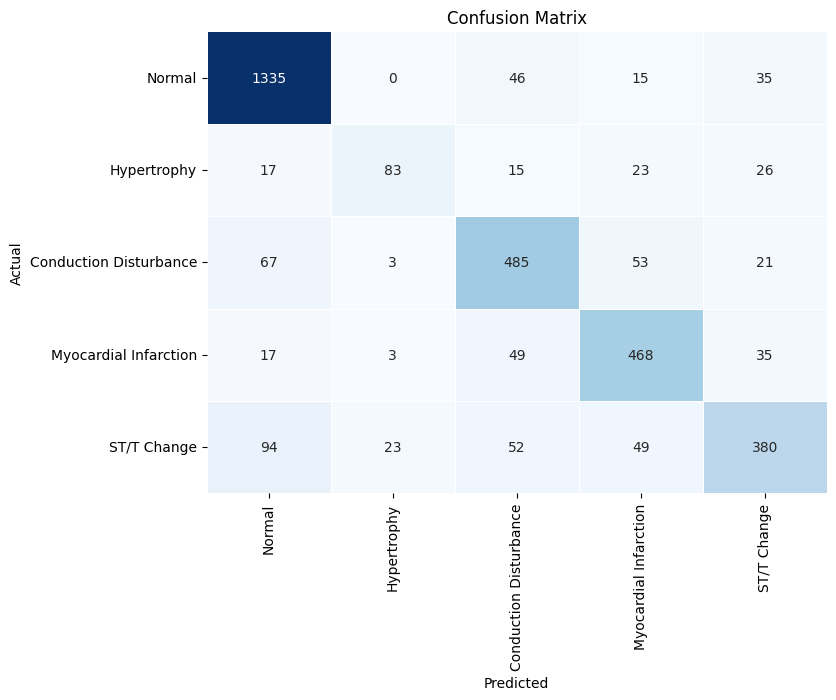


Class-wise Accuracies:
                 Class  Accuracy
                Normal  0.932914
           Hypertrophy  0.506098
Conduction Disturbance  0.771065
 Myocardial Infarction  0.818182
           ST/T Change  0.635452
Validation Loss: 0.5192
Validation Accuracy: 0.8105
F1 Score: 0.8061
Classification Report:
                        precision    recall  f1-score   support

                Normal       0.87      0.93      0.90      1431
           Hypertrophy       0.74      0.51      0.60       164
Conduction Disturbance       0.75      0.77      0.76       629
 Myocardial Infarction       0.77      0.82      0.79       572
           ST/T Change       0.76      0.64      0.69       598

              accuracy                           0.81      3394
             macro avg       0.78      0.73      0.75      3394
          weighted avg       0.81      0.81      0.81      3394

Confusion Matrix:
                        Normal  Hypertrophy  Conduction Disturbance  \
Normal            

In [53]:
class_names = ['Normal', 'Hypertrophy', 'Conduction Disturbance', 'Myocardial Infarction', 'ST/T Change']
DEVICE = torch.device('cuda')

def evaluate_model_with_metrics(model, val_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    class_correct = [0] * len(class_names)
    class_total = [0] * len(class_names)
    
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            for i in range(len(labels)):
                label = labels[i].item()
                class_total[label] += 1
                if predicted[i].item() == label:
                    class_correct[label] += 1
    
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct / total
    val_f1 = f1_score(all_labels, all_preds, average='weighted')
    val_report = classification_report(all_labels, all_preds, target_names=class_names)
    val_cm = confusion_matrix(all_labels, all_preds)

    # Class-wise accuracy
    class_accuracies = {
        class_names[i]: (class_correct[i] / class_total[i] if class_total[i] > 0 else 0)
        for i in range(len(class_correct))
    }

    # Create confusion matrix DataFrame
    cm_df = pd.DataFrame(val_cm, index=class_names, columns=class_names)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False, linewidths=0.5)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    # Class-wise accuracy DataFrame
    class_accuracy_df = pd.DataFrame(
        {"Class": list(class_accuracies.keys()), "Accuracy": list(class_accuracies.values())}
    )

    # Print the class-wise accuracy table
    print("\nClass-wise Accuracies:")
    print(class_accuracy_df.to_string(index=False))

    return avg_val_loss, val_accuracy, val_f1, val_report, cm_df, class_accuracies

# Define your model and criterion
criterion = torch.nn.CrossEntropyLoss()
checkpoint = torch.load('model_multicls_cnn.pth')
model = ECGSegmentClassifier().to(DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])

# Evaluate the model
val_loss, val_accuracy, val_f1, val_report, cm_df, class_accuracies = evaluate_model_with_metrics(
    model, test_loader, criterion, DEVICE
)

# Print the results
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"F1 Score: {val_f1:.4f}")
print(f"Classification Report:\n{val_report}")
print(f"Confusion Matrix:\n{cm_df}")

In [65]:
def save_model(model, optimizer, epoch, train_losses, val_losses, train_accuracies, val_accuracies, filename="model_multicls_cnn.pth"):
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
    }
    torch.save(checkpoint, filename)

save_model(model=model, optimizer=optimizer, epoch=10, train_losses=train_losses, val_losses=val_losses, train_accuracies=train_accuracies, val_accuracies=val_accuracies)